In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from 'C:\\Users\\yt02izug\\AppData\\Local\\miniconda3\\envs\\gammapy-1.0-irf\\lib\\site-packages\\gammapy\\__init__.py'>


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation_Test import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

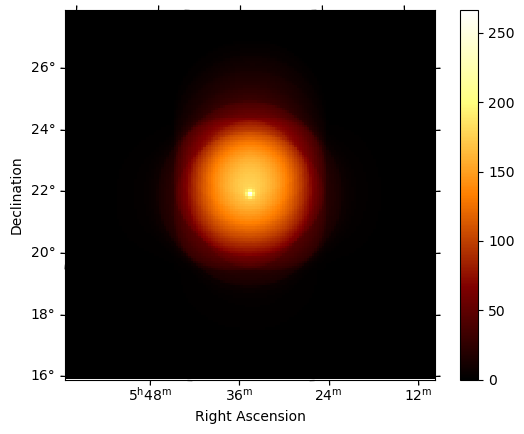

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Asimov Cases and Varying Amplitude

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

# energy independent method: pm 10%
shift_neg = -0.1#-0.085
shift_pos = 0.1#+0.085
shift_cor = 0.0

tilt_neg = 1e-24 #-0.015 # 1e-24 for computational purposes -> covmatrix "1/0"
tilt_pos = 0. #0.015
tilt_cor = 0.

print(tilt_neg)

1e-24


In [5]:
amplitude_array = [1e-12, 1e-11, 1e-10]

sigma_spatial = 0.02

In [6]:
#initialize asimov datasets with different amplitude
dataset_asimov_array = []
for i, a in enumerate(amplitude_array):
    dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
    # Create the spatial model 
    model_spatial = GaussianSpatialModel(
        lon_0="83.631 deg",
        lat_0="22.018 deg",
        sigma=f"{sigma_spatial} deg",
        )

    # Create the spectral model 
    model_spectrum  = ExpCutoffPowerLawSpectralModel(
        index=2.3,
        amplitude=f"{a} TeV-1 cm-2 s-1",
        lambda_="0.1 TeV-1"
    )

    # combine the spectral and the spatial model
    source_model = SkyModel(spatial_model = model_spatial ,
                           spectral_model = model_spectrum,
                           name = "Source")    
    models = Models(source_model)

    # Create the model for the Background
    bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
    bkg_model.parameters['tilt'].frozen  = False
    models.append(bkg_model)

    # set the models in the dataset
    dataset_asimov.models = models
    # set counts
    dataset_asimov.counts = dataset_asimov.npred()
    
    dataset_asimov_array.append(dataset_asimov)

In [8]:
datasets_N_array = []
for i, a in enumerate(amplitude_array):
    sys_d_cor = sys_dataset(dataset_asimov, shift_cor, tilt_cor, False, a, sigma_spatial)
    dataset_cor_N = sys_d_cor.create_dataset_N()

    sys_d_neg = sys_dataset(dataset_asimov, shift_neg, tilt_neg, False, a, sigma_spatial)
    dataset_neg_N = sys_d_neg.create_dataset_N()

    sys_d_pos = sys_dataset(dataset_asimov, shift_pos, tilt_pos, False, a, sigma_spatial)
    dataset_pos_N = sys_d_pos.create_dataset_N()

    zero = 1e-24
    ## additional parameter bias and resolution (ereco) but are frozen
    penalising_invcovmatrix = np.zeros((4, 4))
    np.fill_diagonal(penalising_invcovmatrix,
                     [1/shift_neg**2, 1/tilt_neg**2, 1/zero**2, 1/zero**2])

    dataset_pos_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_neg_N.penalising_invcovmatrix = penalising_invcovmatrix

    datasets  = [dataset_pos_N, dataset_cor_N, dataset_neg_N]
    datasets_N_array.append([dataset_neg_N, dataset_cor_N, dataset_pos_N])

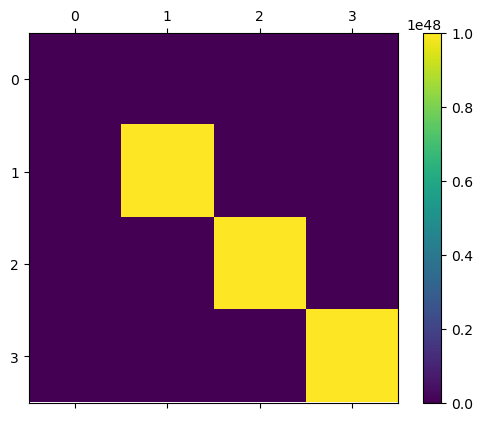

In [9]:
fig, ax = plt.subplots(1,1)
#ax = fig.add_subplot(111)
cax = ax.matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);
#cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
#fig.colorbar(cax);

In [10]:
%%time
for i, a in enumerate(amplitude_array):
    print(a)
    
    print("corr")
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(datasets_N_array[i][1])

    print("neg")
    fit_neg = Fit(store_trace=False)
    result_neg = fit_neg.run(datasets_N_array[i][0])

    print("pos")
    fit_pos = Fit(store_trace=False)
    result_pos = fit_pos.run(datasets_N_array[i][2])

1e-12
corr
neg
pos
1e-11
corr
neg
pos
1e-10
corr
neg
pos
CPU times: total: 46min 44s
Wall time: 11min 51s


In [13]:
amplitudes_N_array = []
indices_N_array = []
norms_N_array = []
lambdas_N_array = []
for i, a in enumerate(amplitude_array):    
    datasets_short = datasets_N_array[i]
    dataset_asimov = dataset_asimov_array[i]
    print(a)
    
    print("best fit amplitude")
    amplitudes_N = []
    m = dataset_asimov.models[0]
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))
    print('====')
    print('Input')
    print(f'{value} pm {error}')
    print('====')
    for d in datasets_short:
        m = d.models[0]
        value = m.parameters['amplitude'].value 
        error = m.parameters['amplitude'].error
        amplitudes_N.append((value, error))
        print(f'{value} pm {error}')
    print()
    print("best fit Index")
    indices_N = []
    m = dataset_asimov.models[0]
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    print('====')
    print('Input')
    print(f'{value} pm {error}')
    print('====')
    for d in datasets_short:
        m = d.models[0]
        value = m.parameters['index'].value 
        error = m.parameters['index'].error
        indices_N.append((value, error))
        print(f'{value} pm {error}')
    print()

    print("Best Fit bkg Norm")
    norms_N = []
    value = dataset_asimov.background_model.parameters['norm'].value 
    error = dataset_asimov.background_model.parameters['norm'].error
    norms_N.append((value, error))
    print('====')
    print('Input')
    print(f'{value} pm {error}')
    print('====')
    for d in datasets_short:
        value = d.background_model.parameters['norm'].value 
        error = d.background_model.parameters['norm'].error
        print(f'{value} pm {error}')
        norms_N.append((value, error))
    print()   

    print("Best Fit Lambda Norm")
    lambdas_N = []
    value = dataset_asimov.models.parameters['lambda_'].value 
    error = dataset_asimov.models.parameters['lambda_'].error
    lambdas_N.append((value, error))
    print('====')
    print('Input')
    print(f'{value} pm {error}')
    print('====')
    for d in datasets_short:
        value = d.models.parameters['lambda_'].value 
        error = d.models.parameters['lambda_'].error
        print(f'{value} pm {error}')
        lambdas_N.append((value, error))
    print() 
    
    amplitudes_N_array.append(amplitudes_N)
    indices_N_array.append(indices_N)
    norms_N_array.append(norms_N)
    lambdas_N_array.append(lambdas_N)

1e-12
best fit amplitude
====
Input
1e-12 pm 0
====
1.115417478000607e-12 pm 1.8997711732595717e-13
1.002070932463978e-12 pm 1.7076839189931214e-13
9.141597570188711e-13 pm 1.5642615296069138e-13

best fit Index
====
Input
2.3 pm 0
====
2.3113125893862216 pm 0.15743583751095244
2.3023927494542455 pm 0.15791396671867078
2.2970352645985717 pm 0.15826191812027646

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.000005826194188 pm 0.0020665696662136037
1.0000081844135018 pm 0.002066564024450593
1.0000046277924095 pm 0.0020665673029770485

Best Fit Lambda Norm
====
Input
0.1 pm 0
====
0.09814150569801931 pm 0.04728555175403316
0.10034607226086939 pm 0.04764221548382122
0.1025307450827515 pm 0.048144402851701885

1e-11
best fit amplitude
====
Input
1e-11 pm 0
====
1.1140313933519971e-11 pm 1.402237153438984e-12
1.0014602341738825e-11 pm 1.249769517871309e-12
9.114548301535506e-12 pm 1.1387833605649443e-12

best fit Index
====
Input
2.3 pm 0
====
2.3112310037478823 pm 0.0433311247086573
2.311029

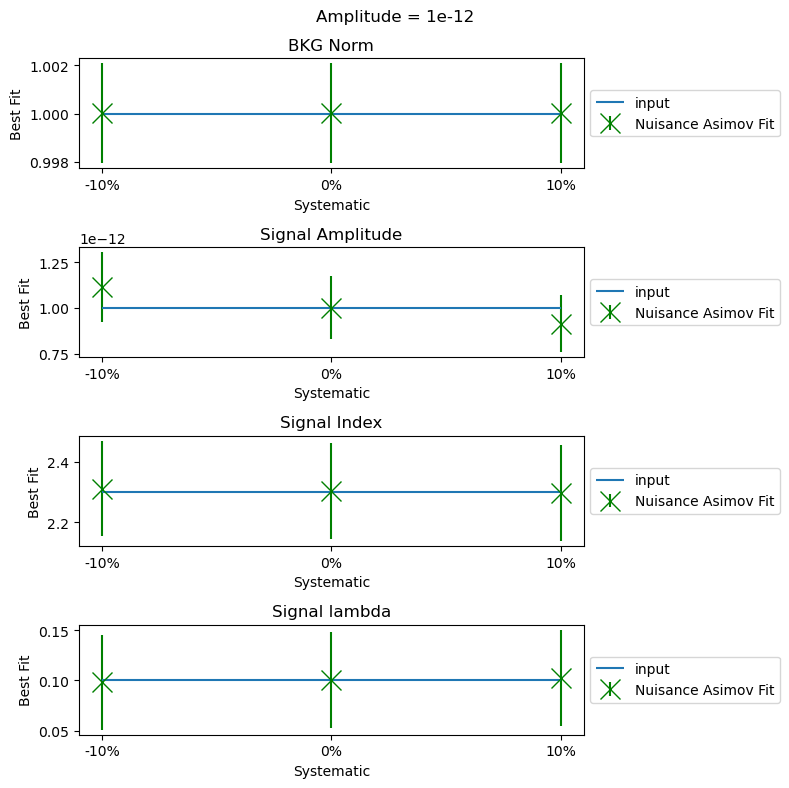

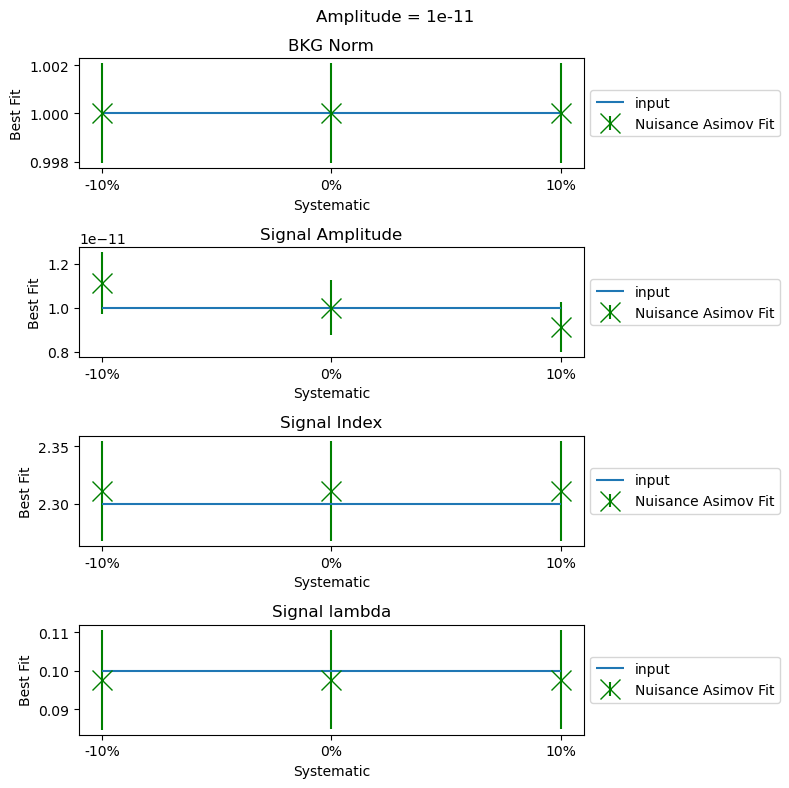

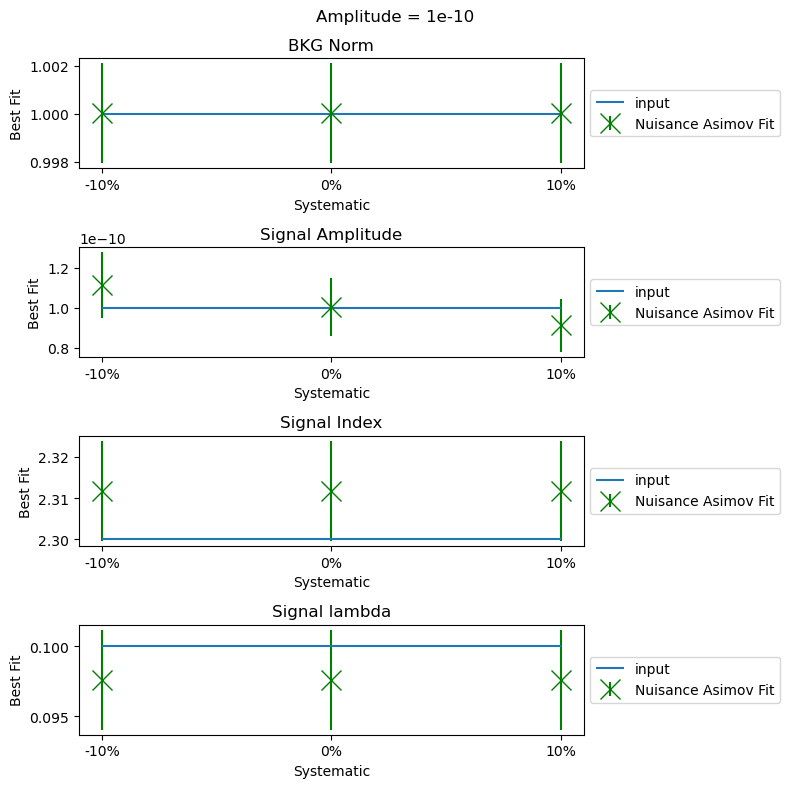

In [14]:
for i, A in enumerate(amplitude_array):
    norms_N = norms_N_array[i]
    amplitudes_N = amplitudes_N_array[i]
    indices_N = indices_N_array[i]
    lambdas_N = lambdas_N_array[i]
    
    fig, axs = plt.subplots(4,1, figsize=(8,8))

    axs[0].set_title("BKG Norm")
    axs[1].set_title("Signal Amplitude")
    axs[2].set_title("Signal Index")
    axs[3].set_title("Signal lambda")


    labels_sys = ['-10%', '0%', '10%']
    label = "Nuisance Asimov Fit"

    for i, a in enumerate(norms_N[1:]):
        axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                       label = label)
    axs[0].hlines( norms_N[0][0], 1, 3, label = "input")

    for i, a in enumerate(amplitudes_N[1:]):
        axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                       label = label)
    axs[1].hlines( amplitudes_N[0][0], 1, 3, label = "input")

    for i, a in enumerate(indices_N[1:]):
        axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                       label = label)
    axs[2].hlines( indices_N[0][0], 1, 3, label = "input")

    for i, a in enumerate(lambdas_N[1:]):
        axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                       label = label)
    axs[3].hlines(lambdas_N[0][0], 1, 3, label = "input")

    plt.tight_layout()
    for a in axs:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        a.legend(by_label.values(), by_label.keys(),
                loc='center left', bbox_to_anchor=(1, 0.5))
        a.set_ylabel('Best Fit'); 
        a.set_xlabel('Systematic'); 
        a.set_xticks(np.arange(3)+1,labels_sys)
    plt.suptitle(f'Amplitude = {A}')
    plt.tight_layout()    
    fig.savefig(f"best_fit_parameters_corr_A{A}.pdf")   


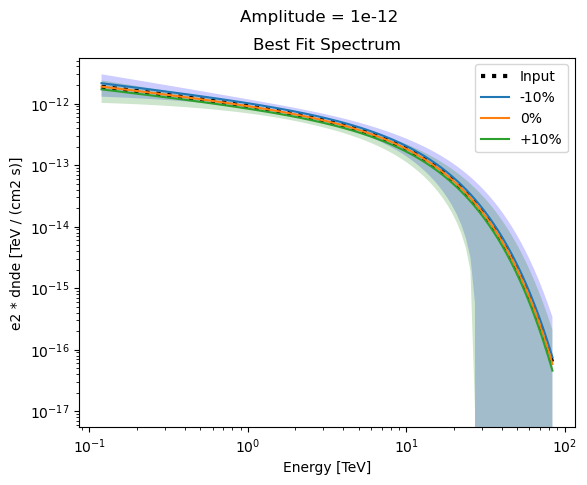

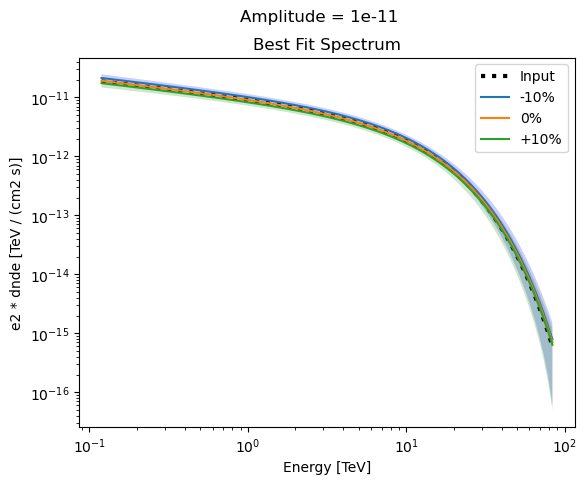

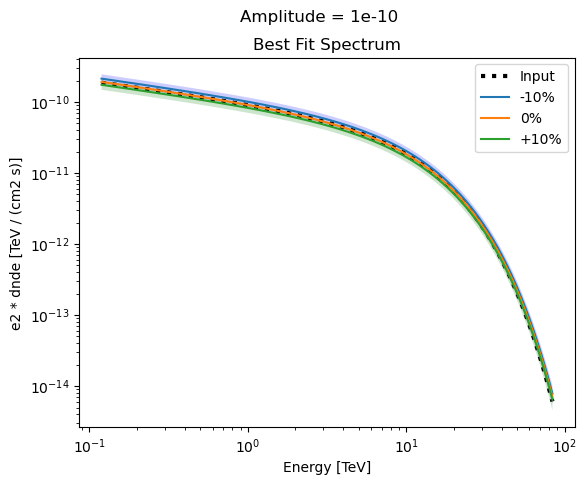

In [15]:
for i, A in enumerate(amplitude_array):
    dataset_cor_N = datasets_N_array[i][1]
    dataset_neg_N = datasets_N_array[i][0]
    dataset_pos_N = datasets_N_array[i][2]
    dataset_asimov = dataset_asimov_array[i]
    
    true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


    fig,ax = plt.subplots()
    energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
    dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                   label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

    dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                    label = "-10%")
    dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                           facecolor='blue')

    dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                    label = "0%")

    #dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
    #                                                       facecolor='orange')



    dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                    label = "+10%")
    dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                            facecolor = 'green')


    plt.legend()
    plt.suptitle(f'Amplitude = {A}')
    plt.title("Best Fit Spectrum")
    fig = plt.gcf()
    #fig.savefig(f"plots/2d_spectrum_A{A}.pdf")

In [11]:
#print(dataset_asimov)

-0.0003231870587069259 0.10750085098884794
0.0009830538820573198 0.10733773476609963
0.00018025675056410756 0.10748059738565154
0.0 1e-24
0.0 1e-24
0.0 1e-24
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-0.00043842293256887493 0.12287793818822283
0.0006797956316128586 0.12195864154241776
-0.0004933371319230419 0.12196558795404809
0.0 1e-24
0.0 1e-24
0.0 1e-24
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0006958536051648566 0.14858393991699492
0.0010725572498268693 0.1451028029274566
-0.00015707473296198472 0.14697899750414556
0.0 1e-24
0.0 1e-24
0.0 1e-24
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


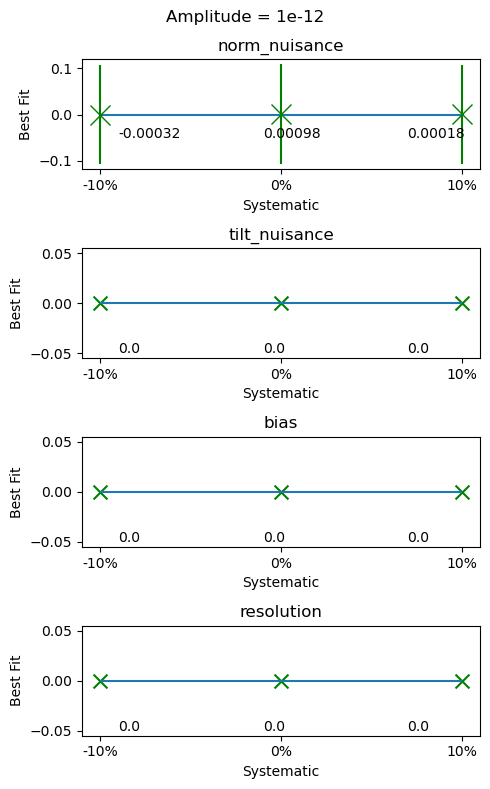

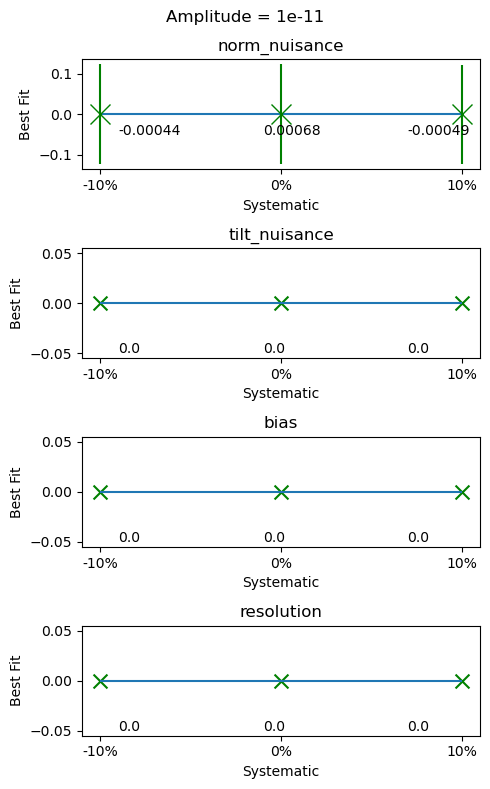

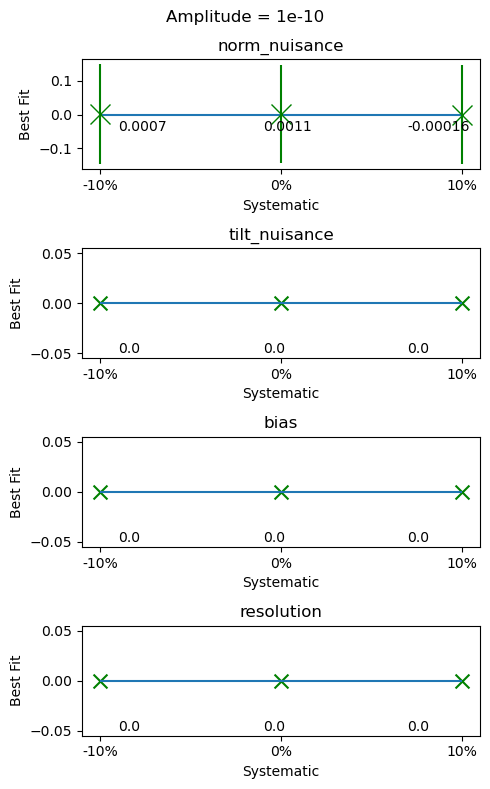

In [16]:
for i, A in enumerate(amplitude_array):
    dataset_cor_N = datasets_N_array[i][1]
    dataset_neg_N = datasets_N_array[i][0]
    dataset_pos_N = datasets_N_array[i][2]
    dataset_asimov = dataset_asimov_array[i]
    n_nui = len(dataset_neg_N.models.parameters.penalised_parameters)
    fig, a  = plt.subplots(n_nui, 1, figsize = (5,2* n_nui))
    if n_nui ==1:
        a = [a]
    label = 'Nuisance Fit'
    iss = [1.1, 1.9, 2.7]
    for j, par_name in enumerate(dataset_neg_N.models.parameters.penalised_parameters.names):
        for i, d in enumerate([dataset_neg_N, dataset_cor_N, dataset_pos_N]):
            value = d.models.parameters[par_name].value
            error = d.models.parameters[par_name].error
            print(value, error)
            if error > 1e-24:
                a[j].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color = 'green', markersize=14,
                           label = label)
            else:
                a[j].scatter(i+1, value, color = 'green', marker = 'x', s=100,
                           label = label)
            a[j].text(iss[i],-0.05, f'{value:.2}', )
        a[j].hlines( 0., 1, 3, label = "input")

        a[j].set_ylabel('Best Fit' ); 
        a[j].set_title(par_name)
        a[j].set_xlabel('Systematic'); 
        a[j].set_xticks(np.arange(3)+1,labels_sys);
    plt.suptitle(f'Amplitude = {A}')
    plt.tight_layout()
    #fig.savefig(f"plots/2d_best_fit_nui_A{A}.pdf")

## Comparison

In [19]:
norms_array = []
amplitudes_array = []
indices_array = []
lambdas_array = []
for a in amplitude_array:
    with open(f'data/1c_norms_A{a}.yaml') as file:
        norms = yaml.load( file, Loader=yaml.FullLoader)
    with open(f'data/1c_amplitudes_A{a}.yaml') as file:
        amplitudes = yaml.load( file, Loader=yaml.FullLoader)
    with open(f'data/1c_indices_A{a}.yaml') as file:
        indices = yaml.load( file, Loader=yaml.FullLoader)
    with open(f'data/1c_lambdas_A{a}.yaml') as file:
        lambdas = yaml.load( file, Loader=yaml.FullLoader)
    norms_array.append(norms)
    amplitudes_array.append(amplitudes)
    indices_array.append(indices)
    lambdas_array.append(lambdas)

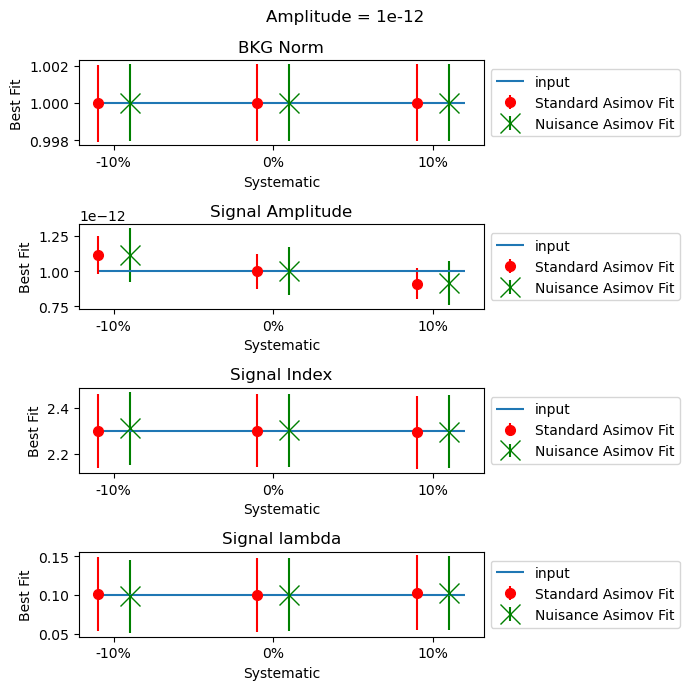

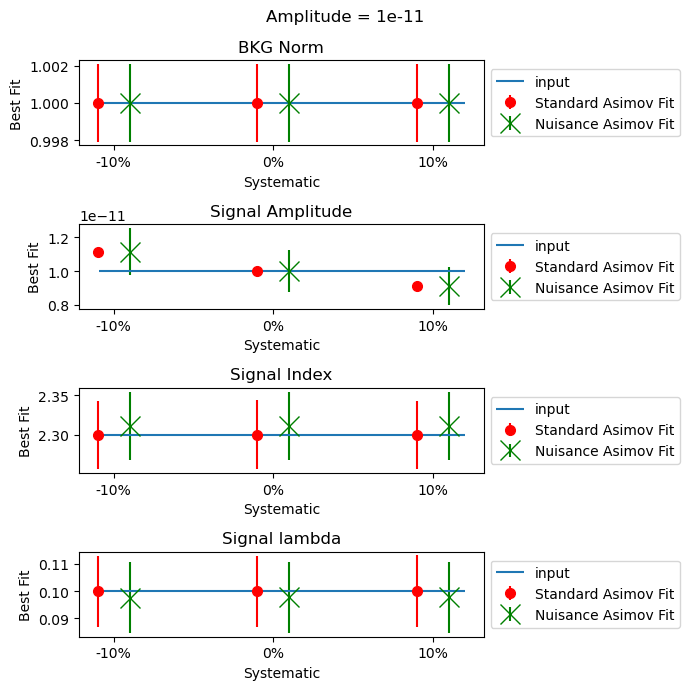

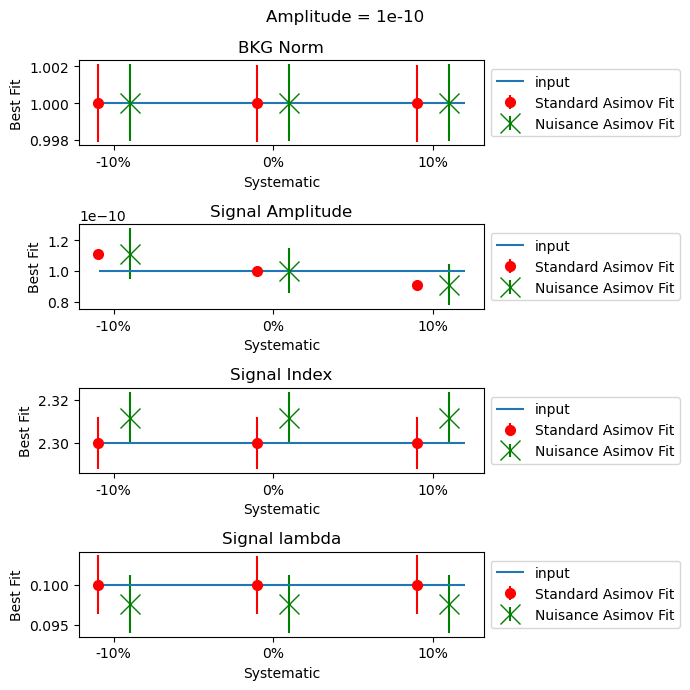

In [21]:
for i, A in enumerate(amplitude_array):
    norms = norms_array[i]
    amplitudes = amplitudes_array[i]
    indices = indices_array[i]
    lambdas = lambdas_array[i]
    norms_N = norms_N_array[i]
    amplitudes_N = amplitudes_N_array[i]
    indices_N = indices_N_array[i]
    lambdas_N = lambdas_N_array[i]
    
    fig, axs = plt.subplots(4,1, figsize= (7, 7))

    axs[0].set_title("BKG Norm")
    axs[1].set_title("Signal Amplitude")
    axs[2].set_title("Signal Index")
    axs[3].set_title("Signal lambda")


    labels_sys = [ '-10%', '0%', '10%']

    for i, a in enumerate(norms[1:]):
        label = "Standard Asimov Fit"
        axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                       label = label)
    for i, a in enumerate(amplitudes[1:]):
        axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                       label = label)
    for i, a in enumerate(indices[1:]):
        axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                       label = label)
    for i, a in enumerate(lambdas[1:]):
        axs[3].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                       label = label)

    for i, a in enumerate(norms_N[1:]):
        label = "Nuisance Asimov Fit"
        axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                       label = label)
    for i, a in enumerate(amplitudes_N[1:]):
        axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                       label = label)
    for i, a in enumerate(indices_N[1:]):
        axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                       label = label)
    for i, a in enumerate(lambdas_N[1:]):
        axs[3].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                       label = label)
    axs[2].hlines( indices[0][0], 0.91, 3.2, label = "input")
    axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
    axs[1].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")
    axs[3].hlines( lambdas[0][0], 0.91, 3.2, label = "input")

    plt.tight_layout()
    for ax in axs:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
                loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_ylabel('Best Fit'); 
        ax.set_xlabel('Systematic'); 
        ax.set_xticks(np.arange(3)+1,labels_sys)

    plt.suptitle(f'Amplitude = {A}')
    #axs[0].set_ylim(0.85, 1.15)
    plt.tight_layout()    
    fig.savefig(f"plots/2d_best_fit_parameters_comparison_A{A}.pdf")   


### Spectrum

In [44]:
dataset_st_array = []
for i, a in enumerate(amplitude_array):
    dataset_cor_N = datasets_N_array[i][1]
    dataset_neg_N = datasets_N_array[i][0]
    dataset_pos_N = datasets_N_array[i][2]
    
    dataset_st_neg = dataset_neg_N.copy()
    dataset_st_neg.models = Models.read(f"data/1c_model_neg_A{a}.yml")
    
    dataset_st_pos = dataset_pos_N.copy()
    dataset_st_pos.models = Models.read(f"data/1c_model_pos_A{a}.yml")

    dataset_st_cor = dataset_cor_N.copy()
    dataset_st_cor.models = Models.read(f"data/1c_model_cor_A{A}.yml")
    
    dataset_st_array.append([dataset_st_neg, dataset_st_cor, dataset_st_pos])

In [45]:
for i, a in enumerate(amplitude_array):
    for d in datasets_N_array[i]:
        for p in d.models.parameters.penalised_parameters:
            p.frozen = True

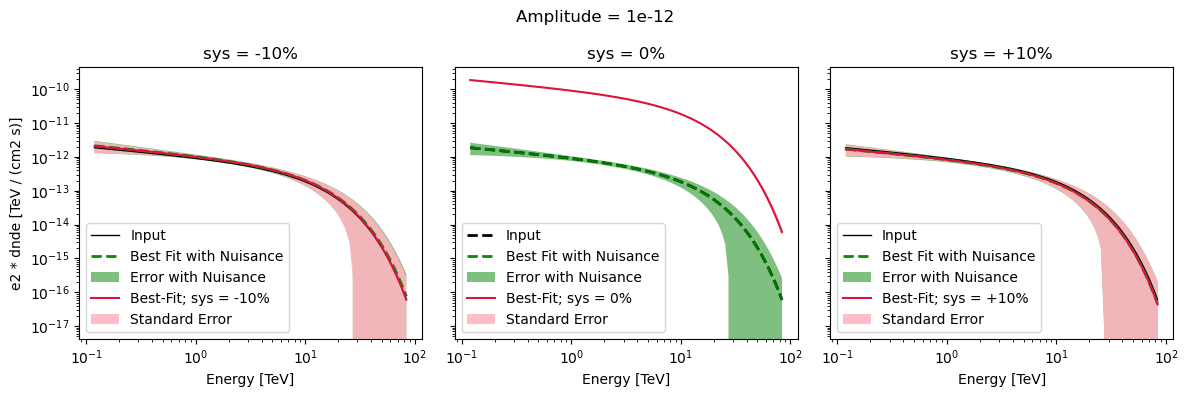

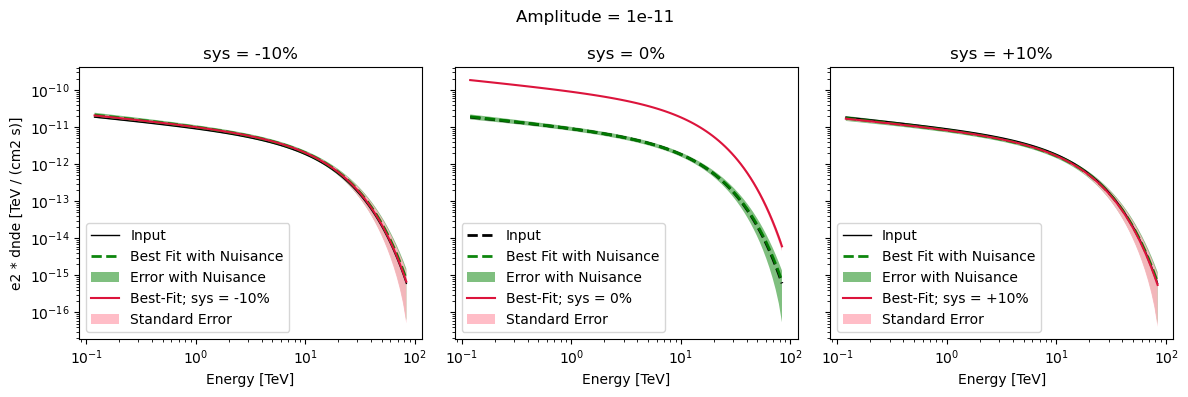

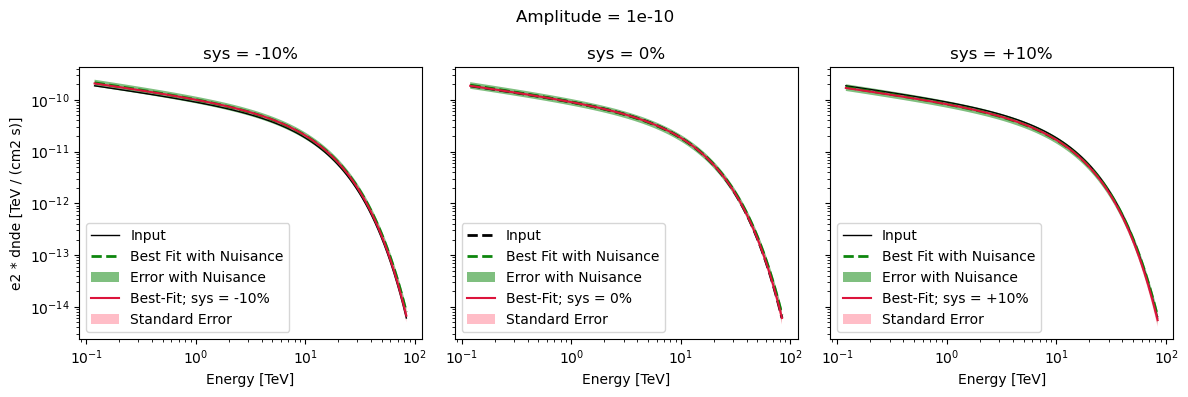

In [46]:
for i, A in enumerate(amplitude_array):
    dataset_cor_N = datasets_N_array[i][1]
    dataset_neg_N = datasets_N_array[i][0]
    dataset_pos_N = datasets_N_array[i][2]
    
    dataset_asimov = dataset_asimov_array[i]
    
    dataset_st_neg = dataset_st_array[i][0]
    dataset_st_cor = dataset_st_array[i][1]
    dataset_st_pos = dataset_st_array[i][2]
    
    true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
    energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
    fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

    for i,ax in enumerate(axs):
        if i ==1:
             dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                    label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
        else:
            dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                    label = "Input", color = 'black', linewidth = 1, )


    dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                                           color='green',
                                                             label="Best Fit with Nuisance",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)        
    dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                           facecolor='green',
                                                             label="Error with Nuisance",
                                                            alpha = 0.5)
    dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                    label = "Best-Fit; sys = -10%", color = "crimson")
    dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                           facecolor='lightpink',
                                                              alpha = 0.9,
                                                              label= "Standard Error"
                                                             )
    ### cor 
    dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],color = 'green',
                                                             label="Best Fit with Nuisance",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)
    dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                           facecolor='green',
                                                             label="Error with Nuisance",
                                                            alpha = 0.5)
    dataset_st_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                    label = "Best-Fit; sys = 0%", color = "crimson")
    dataset_st_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                           facecolor='lightpink',
                                                              alpha = 0.9,
                                                              label= "Standard Error"
                                                             )
    ### pos 
    dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],color = 'green',
                                                                   label="Best Fit with Nuisance",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)                                              

    dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                           facecolor='green',
                                                             label="Error with Nuisance",
                                                            alpha = 0.5)
    dataset_st_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                    label = "Best-Fit; sys = +10%", color = "crimson")
    dataset_st_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                          facecolor='lightpink',
                                                              alpha = 0.9,
                                                              label= "Standard Error"
                                                             )
    [a.legend() for a in axs]
    axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

    axs[1].set_ylabel('')
    axs[2].set_ylabel('')
    plt.suptitle(f'Amplitude = {A}')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(f"plots/2d_spectrum_comparison_A{A}.pdf")